In [ ]:
'''
10_preprocess.ipynb

목적: 날짜/분야/키워드 정리 + 네트워크 분석용 컬럼 생성

입력: data/interim/papers.parquet

출력: data/interim/papers_clean.parquet, outputs/figures/*

핵심 컬럼: year, field1, field2, kw_list, kw_list_f, kw_n

주의: 키워드 없는 논문은 네트워크에서 제외(별도 분석 가능)
'''

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

In [ ]:
BASE = "/content/drive/MyDrive/SSU_Datathon2025"

papers = pd.read_parquet(f"{BASE}/papers.parquet")

In [ ]:
print("shape:", papers.shape)
print("columns:", papers.columns.tolist())
papers.head(3)

shape: (62199, 13)
columns: ['NODE_ID', 'IPRD_NM', 'PLCT_NM', 'NODE_TTLE', 'NODE_TTLE_EN', 'PBSH', 'NODE_LINK', 'NODE_CLSS_01', 'NODE_CLSS_02', 'AUTR_NM', 'KYWD', 'ABST_KR', 'ABST_EN']


,NODE_ID,IPRD_NM,PLCT_NM,NODE_TTLE,NODE_TTLE_EN,PBSH,NODE_LINK,NODE_CLSS_01,NODE_CLSS_02,AUTR_NM,KYWD,ABST_KR,ABST_EN
0,NODE10561230,제어로봇시스템학회,제어로봇시스템학회 논문지,카테시안 공간에서 시간 지연제어기의 구현에 대한 튜토리얼,Tutorial on Implementation of Time-delayed Con...,202106,https://www.dbpia.co.kr/journal/articleDetail?...,공학,전기전자공학,정슬,"Robot control,robot manipulators,time-delayed ...",,This paper presents a tutorial on the implemen...
1,NODE10561231,제어로봇시스템학회,제어로봇시스템학회 논문지,파이프 구조물 검사를 위한 파이프 등반 로봇의 위치 추적,Position Tracking of Pipe-Climbing Robot for P...,202106,https://www.dbpia.co.kr/journal/articleDetail?...,공학,전기전자공학,"이스라엘, 권영재, 이성욱, 김재희, 박종원","pipe-climbing,pipe climbing robot,location tra...",,In nuclear power plants and petrochemical plan...
2,NODE10561232,제어로봇시스템학회,제어로봇시스템학회 논문지,Depth와 Amplitude Image를 이용한 차량 문 주변 장애물 인식 및 거...,Obstacle Recognition and Distance Estimation n...,202106,https://www.dbpia.co.kr/journal/articleDetail?...,공학,전기전자공학,"홍순원, 이동현, 류춘우, 김학일","ToF (Time of Flight) camera,depth image,amplit...",,Vehicle-related accidents can occur not only w...


In [ ]:
papers = papers.replace(r"^\s*$", np.nan, regex=True)

missing = papers.isna().sum().sort_values(ascending=False)
missing.head(15)

,0
ABST_KR,35862
ABST_EN,16414
KYWD,16411
NODE_TTLE_EN,10650
NODE_ID,0
NODE_TTLE,0
PLCT_NM,0
IPRD_NM,0
PBSH,0
NODE_CLSS_02,0


In [ ]:
papers["PBSH_str"] = papers["PBSH"].astype(str)

mask = papers["PBSH_str"].str.fullmatch(r"\d{6}", na=False)
papers = papers[mask].copy()

papers["year"] = papers["PBSH_str"].str.slice(0, 4).astype(int)
papers["month"] = papers["PBSH_str"].str.slice(4, 6).astype(int)

papers = papers[(papers["month"] >= 1) & (papers["month"] <= 12)].copy()

print("year range:", papers["year"].min(), "-", papers["year"].max())
papers[["PBSH", "year", "month"]].head(5)

year range: 2021 - 2025


,PBSH,year,month
0,202106,2021,6
1,202106,2021,6
2,202106,2021,6
3,202106,2021,6
4,202106,2021,6


In [ ]:
papers["field1"] = papers["NODE_CLSS_01"].astype(str).str.strip()
papers["field2"] = papers["NODE_CLSS_02"].astype(str).str.strip()

print(papers["field1"].value_counts().head(20))

field1
공학    62199
Name: count, dtype: int64


In [ ]:
def parse_keywords(s):
    if pd.isna(s):
        return []
    s = str(s).strip()
    if s == "":
        return []
    kws = re.split(r"\s*,\s*", s)
    kws = [k.strip().lower() for k in kws if k.strip()]
    return kws

papers["kw_list"] = papers["KYWD"].apply(parse_keywords)

kw_len = papers["kw_list"].apply(len)
print(kw_len.describe())

papers[["KYWD", "kw_list"]].head(5)

count    62199.000000
mean         4.559864
std          3.427246
min          0.000000
25%          0.000000
50%          5.000000
75%          6.000000
max         28.000000
Name: kw_list, dtype: float64


,KYWD,kw_list
0,"Robot control,robot manipulators,time-delayed ...","[robot control, robot manipulators, time-delay..."
1,"pipe-climbing,pipe climbing robot,location tra...","[pipe-climbing, pipe climbing robot, location ..."
2,"ToF (Time of Flight) camera,depth image,amplit...","[tof (time of flight) camera, depth image, amp..."
3,"adaptive notch filter,time-frequency analysis,...","[adaptive notch filter, time-frequency analysi..."
4,"MEMS/FOG,Inertial Navigation System,Two stage ...","[mems/fog, inertial navigation system, two sta..."


In [ ]:
# kw_list 길이
papers["kw_n"] = papers["kw_list"].apply(len)
print("kw_n value counts (top):")
print(papers["kw_n"].value_counts().head(10))

# 분석용: 키워드 2개 이상만 (네트워크는 최소 2개 필요)
papers_net = papers[papers["kw_n"] >= 2].copy()
print("papers_net shape:", papers_net.shape)

kw_n value counts (top):
kw_n
5     16522
0     16411
4      7660
10     6435
6      4798
8      3624
3      2277
7      1569
9      1209
12      901
Name: count, dtype: int64
papers_net shape: (45778, 20)


In [ ]:
# 키워드 정규화 함수
def norm_kw(k):
    k = k.strip().lower()
    k = re.sub(r"\s+", " ", k)
    k = k.replace("–", "-").replace("—", "-")
    return k

papers_net["kw_list"] = papers_net["kw_list"].apply(lambda ks: [norm_kw(k) for k in ks if norm_kw(k)])
papers_net["kw_n"] = papers_net["kw_list"].apply(len)

print(papers_net["kw_n"].describe())

count    45778.000000
mean         6.195312
std          2.414118
min          2.000000
25%          5.000000
50%          5.000000
75%          8.000000
max         28.000000
Name: kw_n, dtype: float64


In [ ]:
core_map = {
    "ai": {"ai", "artificial intelligence", "인공지능"},
    "machine learning": {"machine learning", "ml", "머신러닝"},
    "deep learning": {"deep learning", "딥러닝", "dnn", "cnn", "rnn"},
    "big data": {"big data", "빅데이터"},
    "iot": {"iot", "internet of things", "사물인터넷"},
    "metaverse": {"metaverse", "메타버스"},
    "sensor": {"sensor", "센서"},
}

inv = {}
for rep, syns in core_map.items():
    for s in syns:
        inv[s.lower()] = rep

def map_core(ks):
    out = []
    for k in ks:
        out.append(inv.get(k, k))
    return out

papers_net["kw_list"] = papers_net["kw_list"].apply(map_core)

In [ ]:
def has_kw(ks, target):
    return target in ks

for t in ["ai", "deep learning", "big data", "iot", "metaverse"]:
    cnt = papers_net["kw_list"].apply(lambda ks: has_kw(ks, t)).sum()
    print(t, "count:", int(cnt))

ai count: 814
deep learning count: 2106
big data count: 241
iot count: 288
metaverse count: 250


In [ ]:
all_kws = [k for ks in papers_net["kw_list"] for k in ks]
freq = Counter(all_kws)

print("unique keywords:", len(freq))
print("top 20 keywords:", freq.most_common(20))

unique keywords: 164282
top 20 keywords: [('deep learning', 2842), ('ai', 1138), ('machine learning', 1121), ('object detection', 411), ('metaverse', 382), ('iot', 354), ('big data', 319), ('covid-19', 292), ('reinforcement learning', 231), ('virtual reality', 224), ('blockchain', 215), ('convolutional neural network', 213), ('optimization', 212), ('lstm', 208), ('computer vision', 201), ('generative ai', 194), ('simulation', 192), ('anomaly detection', 189), ('text mining', 186), ('drone', 180)]


In [ ]:
min_freq = 10
papers_net["kw_list_f"] = papers_net["kw_list"].apply(lambda ks: [k for k in ks if freq[k] >= min_freq])

papers_net["kw_n_f"] = papers_net["kw_list_f"].apply(len)
papers_net2 = papers_net[papers_net["kw_n_f"] >= 2].copy()

print("papers_net2 shape:", papers_net2.shape)
print(papers_net2["kw_n_f"].describe())

papers_net2 shape: (16429, 22)
count    16429.000000
mean         2.958001
std          1.285395
min          2.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         16.000000
Name: kw_n_f, dtype: float64


In [ ]:
papers["field2"].value_counts().head(30)

,count
field2,
전기전자공학,18255
기계공학,12666
건축공학,11464
컴퓨터학,6831
공학 일반,5569
기타 공학,1984
화학공학,1444
재료·에너지공학,1408
산업공학,1392


In [ ]:
print(papers["year"].min(), papers["year"].max())

2021 2025


target papers: 742


field2,건축공학,공학 일반,기계공학,기타 공학,산업공학,재료·에너지공학,전기전자공학,컴퓨터학
year,,,,,,,,
2021,0.074380,0.057851,0.008264,0.049587,0.041322,0.008264,0.404959,0.355372
2022,0.024793,0.099174,0.033058,0.008264,0.082645,0.008264,0.429752,0.314050
2023,0.048780,0.091463,0.030488,0.006098,0.030488,0.006098,0.475610,0.310976
2024,0.046632,0.150259,0.015544,0.005181,0.015544,0.000000,0.466321,0.300518
2025,0.069930,0.111888,0.027972,0.013986,0.020979,0.000000,0.489510,0.265734


/tmp/ipython-input-2835357005.py:29: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2835357005.py:29: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2835357005.py:29: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2835357005.py:29: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2835357005.py:29: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2835357005.py:29: UserWarning: Glyph 52980 (\N{HANGUL SYLLABLE KEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2835357005.py:29: UserWarning: Glyph 54504 (\N{HANGUL SYLLABLE PYU}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

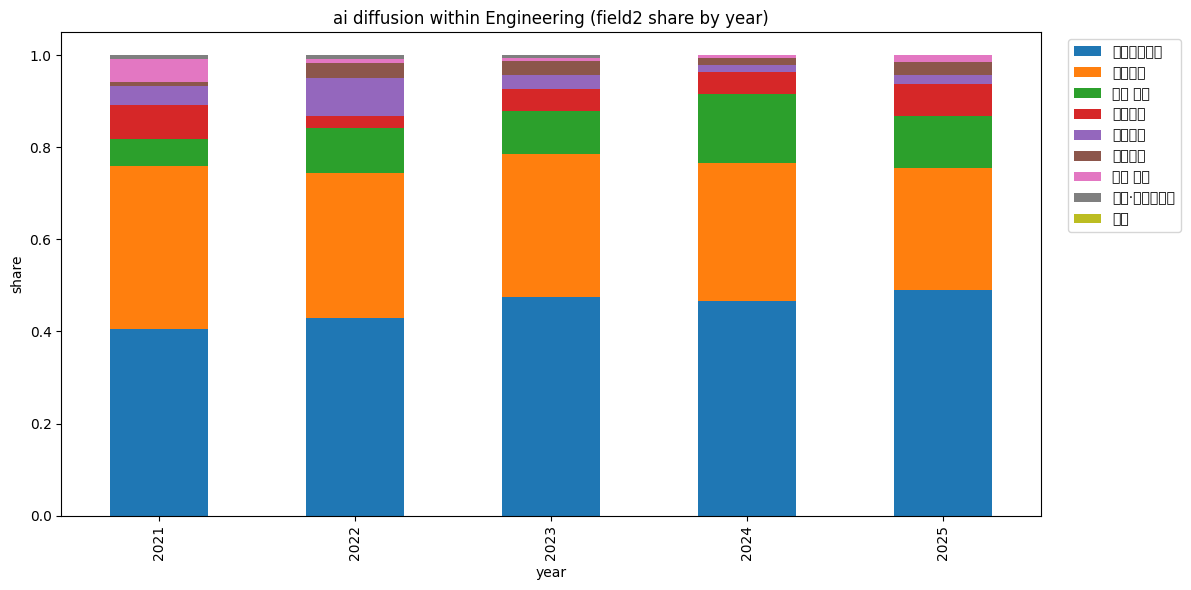

In [ ]:
target = "ai"  # "deep learning", "big data", "iot", "metaverse" 로 바꿔가며 사용

# papers_net2 기준: df_main을 만들지 않았다면 papers_net2 그대로 써도 됨
df_use = papers_net2.copy()
df_use["field2"] = df_use["field2"].fillna("미상").astype(str).str.strip()

# target 포함 논문만
sub = df_use[df_use["kw_list_f"].apply(lambda ks: target in ks)].copy()

# 연도×field2 카운트 -> 비중
g = sub.groupby(["year", "field2"])["NODE_ID"].count().rename("cnt").reset_index()
pivot = g.pivot_table(index="year", columns="field2", values="cnt", fill_value=0)
ratio = pivot.div(pivot.sum(axis=1), axis=0)

print("target papers:", len(sub))
display(ratio)

# 보기 편하게 상위 field2만 + 기타로 묶어서 스택바
top_n = 8
keep = ratio.mean().sort_values(ascending=False).head(top_n).index
plot_df = ratio[keep].copy()
plot_df["기타"] = ratio.drop(columns=keep, errors="ignore").sum(axis=1)

ax = plot_df.plot(kind="bar", stacked=True, figsize=(12, 6))
ax.set_title(f"{target} diffusion within Engineering (field2 share by year)")
ax.set_xlabel("year")
ax.set_ylabel("share")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
target = "ai"
before_years = [2021, 2022]
after_years  = [2024, 2025]

df_use = papers_net2.copy()

def build_kw_network(df_subset, min_co=5, top_kws=150):
    all_kws = [k for ks in df_subset["kw_list_f"] for k in ks]
    top = set([k for k, _ in Counter(all_kws).most_common(top_kws)])

    pair_counts = Counter()
    for ks in df_subset["kw_list_f"]:
        ks = [k for k in set(ks) if k in top]
        ks.sort()
        for i in range(len(ks)):
            for j in range(i + 1, len(ks)):
                pair_counts[(ks[i], ks[j])] += 1

    G = nx.Graph()
    for (a, b), w in pair_counts.items():
        if w >= min_co:
            G.add_edge(a, b, weight=w)
    return G

def top_central_keywords(G, n=15):
    cent = nx.degree_centrality(G)
    return sorted(cent.items(), key=lambda x: x[1], reverse=True)[:n]

# 전/후 데이터 필터 (target 포함)
before = df_use[df_use["year"].isin(before_years) & df_use["kw_list_f"].apply(lambda ks: target in ks)].copy()
after  = df_use[df_use["year"].isin(after_years)  & df_use["kw_list_f"].apply(lambda ks: target in ks)].copy()

print("before papers:", len(before), "after papers:", len(after))

G_before = build_kw_network(before, min_co=5, top_kws=150)
G_after  = build_kw_network(after,  min_co=5, top_kws=150)

print("G_before nodes/edges:", G_before.number_of_nodes(), G_before.number_of_edges())
print("G_after  nodes/edges:", G_after.number_of_nodes(),  G_after.number_of_edges())

print("\nTop central keywords (before):")
for k, v in top_central_keywords(G_before, 15):
    print(k, round(v, 4))

print("\nTop central keywords (after):")
for k, v in top_central_keywords(G_after, 15):
    print(k, round(v, 4))


before papers: 242 after papers: 336
G_before nodes/edges: 17 19
G_after  nodes/edges: 17 17

Top central keywords (before):
ai 1.0
deep learning 0.1875
machine learning 0.1875
object detection 0.125
기계학습 0.125
big data 0.0625
neural network 0.0625
anomaly detection 0.0625
reinforcement learning 0.0625
computer vision 0.0625
iot 0.0625
lstm 0.0625
bigdata 0.0625
data analysis 0.0625
smart factory 0.0625

Top central keywords (after):
ai 1.0
deep learning 0.125
machine learning 0.125
object detection 0.0625
yolo 0.0625
generative ai 0.0625
gpt 0.0625
llm 0.0625
large language model 0.0625
chatgpt 0.0625
artificial intelligence (ai) 0.0625
natural language processing 0.0625
iot 0.0625
metaverse 0.0625
big data 0.0625


In [ ]:
# 전/후 중심 키워드 비교: 신규/급상승 키워드 뽑기

def centrality_dict(G):
    return nx.degree_centrality(G)

c_before = centrality_dict(G_before)
c_after  = centrality_dict(G_after)

# ai 자체는 항상 1.0이라 비교에서 제외
exclude = {"ai"}

before_keys = set(c_before.keys()) - exclude
after_keys  = set(c_after.keys()) - exclude

new_in_after = sorted(list(after_keys - before_keys))
gone_in_after = sorted(list(before_keys - after_keys))

# 급상승: after - before 차이가 큰 순
all_keys = sorted(list((before_keys | after_keys)))
delta = []
for k in all_keys:
    b = c_before.get(k, 0.0)
    a = c_after.get(k, 0.0)
    delta.append((k, a - b, b, a))

delta_sorted = sorted(delta, key=lambda x: x[1], reverse=True)

print("New in AFTER (not in BEFORE):")
for k in new_in_after:
    print("-", k)

print("\nGone in AFTER (only in BEFORE):")
for k in gone_in_after:
    print("-", k)

print("\nTop 상승 키워드 (after - before):")
for k, d, b, a in delta_sorted[:15]:
    print(k, "delta=", round(d, 4), "before=", round(b, 4), "after=", round(a, 4))

New in AFTER (not in BEFORE):
- artificial intelligence (ai)
- chatgpt
- generative ai
- gpt
- large language model
- llm
- metaverse
- natural language processing
- yolo

Gone in AFTER (only in BEFORE):
- anomaly detection
- bigdata
- cloud
- computer vision
- data analysis
- neural network
- smart factory
- 기계학습
- 인공신경망

Top 상승 키워드 (after - before):
artificial intelligence (ai) delta= 0.0625 before= 0.0 after= 0.0625
chatgpt delta= 0.0625 before= 0.0 after= 0.0625
generative ai delta= 0.0625 before= 0.0 after= 0.0625
gpt delta= 0.0625 before= 0.0 after= 0.0625
large language model delta= 0.0625 before= 0.0 after= 0.0625
llm delta= 0.0625 before= 0.0 after= 0.0625
metaverse delta= 0.0625 before= 0.0 after= 0.0625
natural language processing delta= 0.0625 before= 0.0 after= 0.0625
yolo delta= 0.0625 before= 0.0 after= 0.0625
big data delta= 0.0 before= 0.0625 after= 0.0625
iot delta= 0.0 before= 0.0625 after= 0.0625
lstm delta= 0.0 before= 0.0625 after= 0.0625
reinforcement learning de

In [ ]:
# 추가 정규화/동의어 매핑
alias = {
    "기계학습": "machine learning",
    "머신러닝": "machine learning",
    "ml": "machine learning",
    "인공신경망": "neural network",
    "artificial intelligence (ai)": "ai",
    "bigdata": "big data",
    "big-data": "big data",
    "large language model": "llm",
    "large language models": "llm",
}

def normalize_kw(k):
    k = str(k).strip().lower()
    k = re.sub(r"\s+", " ", k)
    k = k.replace("–", "-").replace("—", "-")
    return alias.get(k, k)

# papers_net 기준(키워드 2개 이상)에서 다시 시작해도 되고, papers_net2에서 해도 됨
df = papers_net.copy()

df["kw_list"] = df["kw_list"].apply(lambda ks: [normalize_kw(k) for k in ks if normalize_kw(k)])

# 빈도 다시 계산해서 희귀 제거 재적용
all_kws = [k for ks in df["kw_list"] for k in ks]
freq = Counter(all_kws)

min_freq = 10
df["kw_list_f"] = df["kw_list"].apply(lambda ks: [k for k in ks if freq[k] >= min_freq])

df["kw_n_f"] = df["kw_list_f"].apply(len)
papers_net2 = df[df["kw_n_f"] >= 2].copy()

print("papers_net2 shape:", papers_net2.shape)
print("top 20 keywords:", Counter([k for ks in papers_net2["kw_list_f"] for k in ks]).most_common(20))


papers_net2 shape: (16429, 22)
top 20 keywords: [('deep learning', 2652), ('machine learning', 1184), ('ai', 1090), ('object detection', 383), ('metaverse', 353), ('big data', 335), ('iot', 316), ('covid-19', 242), ('virtual reality', 205), ('lstm', 193), ('convolutional neural network', 188), ('computer vision', 187), ('reinforcement learning', 185), ('blockchain', 184), ('text mining', 180), ('anomaly detection', 172), ('llm', 168), ('optimization', 167), ('generative ai', 167), ('data augmentation', 163)]


In [ ]:
# 분석 대상 핵심 기술 키워드
target = "ai"

# 전이 전/후 비교 구간 (데이터 연도 범위: 2021~2025)
before_years = [2021, 2022]
after_years  = [2024, 2025]

def build_kw_network(df_subset, min_co=5, top_kws=150):
    """
    키워드 공출현(co-occurrence) 네트워크 생성
    - 각 논문에서 함께 등장한 키워드 쌍을 엣지로 연결
    - 너무 희귀한 키워드는 제거하기 위해 top_kws 상위 키워드만 사용
    - min_co 이상 함께 등장한 경우만 엣지로 추가
    """
    # 전체 키워드 빈도 집계 -> 상위 top_kws만 남김(네트워크 노이즈 감소)
    all_kws = [k for ks in df_subset["kw_list_f"] for k in ks]
    top = set([k for k, _ in Counter(all_kws).most_common(top_kws)])

    # 키워드 쌍(조합) 공출현 카운트
    pair_counts = Counter()
    for ks in df_subset["kw_list_f"]:
        ks = [k for k in set(ks) if k in top]  # 중복 제거 + 상위 키워드만
        ks.sort()
        for i in range(len(ks)):
            for j in range(i + 1, len(ks)):
                pair_counts[(ks[i], ks[j])] += 1

    # 그래프 구성
    G = nx.Graph()
    for (a, b), w in pair_counts.items():
        if w >= min_co:  # 최소 공출현 빈도 필터
            G.add_edge(a, b, weight=w)
    return G

def top_central_keywords(G, n=15):
    """
    중심성(여기서는 degree centrality) 상위 키워드 추출
    - degree centrality: 연결이 많은(허브) 키워드를 찾기 쉬움
    """
    cent = nx.degree_centrality(G)
    top = sorted(cent.items(), key=lambda x: x[1], reverse=True)[:n]
    return top, cent

# 분석용 데이터프레임(정규화/희귀제거 완료된 papers_net2 사용)
df_use = papers_net2.copy()

# 전/후 기간에서 target 키워드가 포함된 논문만 필터링
before = df_use[df_use["year"].isin(before_years) & df_use["kw_list_f"].apply(lambda ks: target in ks)].copy()
after  = df_use[df_use["year"].isin(after_years)  & df_use["kw_list_f"].apply(lambda ks: target in ks)].copy()

print("before papers:", len(before), "after papers:", len(after))

# 전/후 네트워크 생성
G_before = build_kw_network(before, min_co=5, top_kws=150)
G_after  = build_kw_network(after,  min_co=5, top_kws=150)

print("G_before nodes/edges:", G_before.number_of_nodes(), G_before.number_of_edges())
print("G_after  nodes/edges:", G_after.number_of_nodes(),  G_after.number_of_edges())

# 전/후 중심 키워드 TOP 출력
top_b, c_before = top_central_keywords(G_before, 15)
top_a, c_after  = top_central_keywords(G_after, 15)

print("\nTop central keywords (before):")
for k, v in top_b:
    print(k, round(v, 4))

print("\nTop central keywords (after):")
for k, v in top_a:
    print(k, round(v, 4))

# 전/후 변화 분석: 신규/소멸/급상승 키워드
exclude = {"ai"}  # ai는 항상 중심(1.0)이라 비교에서 제외

before_keys = set(c_before.keys()) - exclude
after_keys  = set(c_after.keys()) - exclude

# 후에 새로 등장한 키워드 / 후에 사라진 키워드
new_in_after = sorted(list(after_keys - before_keys))
gone_in_after = sorted(list(before_keys - after_keys))

# 중심성 변화량(after - before) 계산
delta = []
for k in sorted(list(before_keys | after_keys)):
    b = c_before.get(k, 0.0)
    a = c_after.get(k, 0.0)
    delta.append((k, a - b, b, a))
delta_sorted = sorted(delta, key=lambda x: x[1], reverse=True)

print("\nNew in AFTER:")
for k in new_in_after:
    print("-", k)

print("\nGone in AFTER:")
for k in gone_in_after:
    print("-", k)

print("\nTop 상승 키워드 (after - before):")
for k, d, b, a in delta_sorted[:15]:
    print(k, "delta=", round(d, 4), "before=", round(b, 4), "after=", round(a, 4))

before papers: 245 after papers: 345
G_before nodes/edges: 14 15
G_after  nodes/edges: 15 15

Top central keywords (before):
ai 1.0
deep learning 0.2308
machine learning 0.1538
object detection 0.1538
big data 0.0769
neural network 0.0769
anomaly detection 0.0769
reinforcement learning 0.0769
computer vision 0.0769
iot 0.0769
lstm 0.0769
data analysis 0.0769
smart factory 0.0769
cloud 0.0769

Top central keywords (after):
ai 1.0
deep learning 0.1429
machine learning 0.1429
object detection 0.0714
yolo 0.0714
generative ai 0.0714
gpt 0.0714
llm 0.0714
chatgpt 0.0714
natural language processing 0.0714
iot 0.0714
big data 0.0714
metaverse 0.0714
lstm 0.0714
reinforcement learning 0.0714

New in AFTER:
- chatgpt
- generative ai
- gpt
- llm
- metaverse
- natural language processing
- yolo

Gone in AFTER:
- anomaly detection
- cloud
- computer vision
- data analysis
- neural network
- smart factory

Top 상승 키워드 (after - before):
chatgpt delta= 0.0714 before= 0.0 after= 0.0714
generative ai de

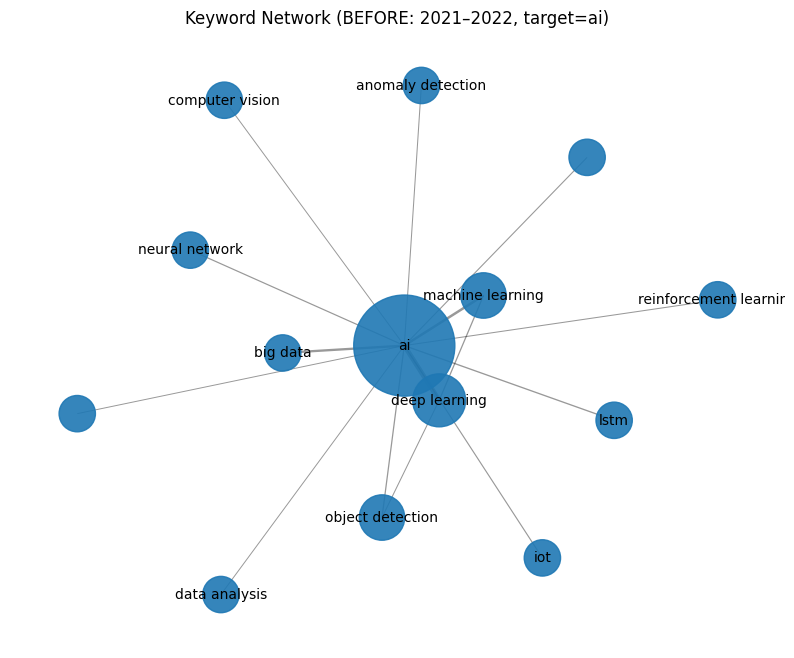

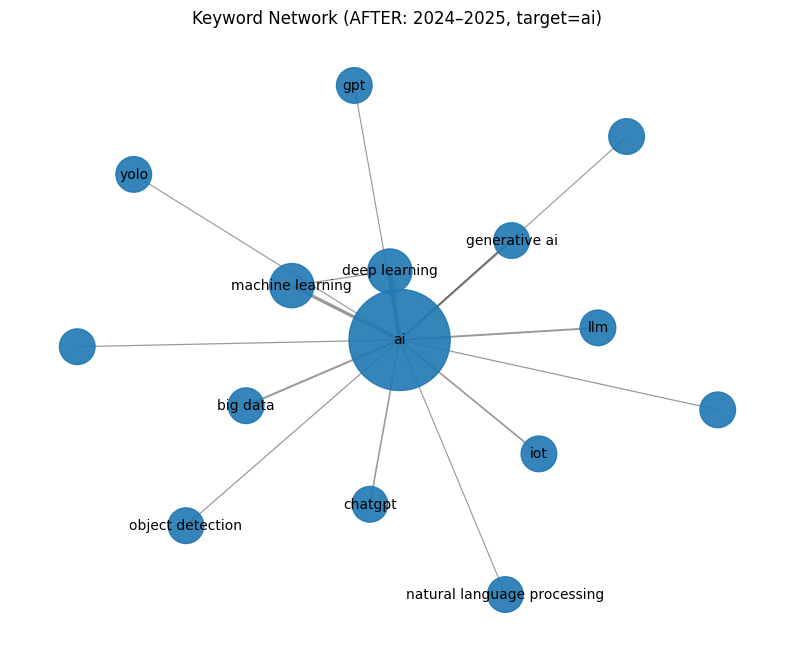

In [ ]:
# 전/후 네트워크 시각화 함수
def draw_network(G, title, top_label_n=12, seed=42):
    """
    G: NetworkX graph (키워드 공출현 네트워크)
    title: 그래프 제목
    top_label_n: 라벨을 붙일 상위 노드 개수(너무 많으면 지저분해서 제한)
    seed: 레이아웃 고정을 위한 시드(재실행해도 비슷한 모양)
    """
    if G.number_of_nodes() == 0:
        print("Graph is empty:", title)
        return

    # 노드 위치(스프링 레이아웃)
    pos = nx.spring_layout(G, seed=seed, k=0.7)

    # 노드 크기: degree centrality 기반 (허브일수록 크게)
    cent = nx.degree_centrality(G)
    node_sizes = [300 + 5000 * cent.get(n, 0) for n in G.nodes()]

    # 엣지 굵기: 공출현 빈도(weight) 기반
    weights = [G[u][v].get("weight", 1) for u, v in G.edges()]
    if len(weights) > 0:
        w_max = max(weights)
        edge_widths = [0.5 + 3.0 * (w / w_max) for w in weights]
    else:
        edge_widths = 1.0

    # 라벨: 중심성 상위 top_label_n개만 표시(가독성)
    top_nodes = sorted(cent.items(), key=lambda x: x[1], reverse=True)[:top_label_n]
    label_nodes = {k for k, _ in top_nodes}
    labels = {n: n for n in G.nodes() if n in label_nodes}

    # 그리기
    plt.figure(figsize=(10, 8))
    plt.title(title)
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.4)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
    plt.axis("off")
    plt.show()

# 전/후 그래프 각각 출력
draw_network(G_before, "Keyword Network (BEFORE: 2021–2022, target=ai)", top_label_n=12, seed=42)
draw_network(G_after,  "Keyword Network (AFTER: 2024–2025, target=ai)",  top_label_n=12, seed=42)

In [ ]:
def top_ai_edges(G, top_n=15):
    """
    그래프에서 ai와 직접 연결된 이웃 키워드를 weight(공출현 빈도) 기준으로 정렬
    (키워드, 공출현 빈도) 리스트
    """
    if "ai" not in G:
        return []
    pairs = []
    for nbr in G.neighbors("ai"):
        w = G["ai"][nbr].get("weight", 1)
        pairs.append((nbr, w))
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs[:top_n]

# 전/후 ai-이웃 키워드 Top
top_before = top_ai_edges(G_before, top_n=15)
top_after  = top_ai_edges(G_after,  top_n=15)

print("Top AI co-occurring keywords (BEFORE: 2021-2022)")
for k, w in top_before:
    print(k, w)

print("\nTop AI co-occurring keywords (AFTER: 2024-2025)")
for k, w in top_after:
    print(k, w)

# 비교용 테이블 전/후 weight
before_dict = dict(top_before)
after_dict = dict(top_after)
keys = sorted(set(before_dict) | set(after_dict))

compare = pd.DataFrame({
    "keyword": keys,
    "before_weight": [before_dict.get(k, 0) for k in keys],
    "after_weight":  [after_dict.get(k, 0) for k in keys],
})
compare["delta"] = compare["after_weight"] - compare["before_weight"]
compare = compare.sort_values(["delta", "after_weight"], ascending=False)

print("\nAI edge weight change table (sorted by delta):")
display(compare)

Top AI co-occurring keywords (BEFORE: 2021-2022)
deep learning 72
machine learning 31
big data 28
lstm 11
object detection 10
neural network 9
iot 8
smart factory 7
anomaly detection 6
reinforcement learning 6
computer vision 5
data analysis 5
cloud 5

Top AI co-occurring keywords (AFTER: 2024-2025)
deep learning 44
machine learning 27
generative ai 17
big data 14
llm 13
iot 11
chatgpt 10
object detection 6
lstm 6
reinforcement learning 6
yolo 5
gpt 5
natural language processing 5
metaverse 5

AI edge weight change table (sorted by delta):


,keyword,before_weight,after_weight,delta
7,generative ai,0,17,17
10,llm,0,13,13
2,chatgpt,0,10,10
8,gpt,0,5,5
13,metaverse,0,5,5
14,natural language processing,0,5,5
19,yolo,0,5,5
9,iot,8,11,3
17,reinforcement learning,6,6,0
12,machine learning,31,27,-4


/tmp/ipython-input-1590324770.py:52: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1590324770.py:52: UserWarning: Glyph 52629 (\N{HANGUL SYLLABLE CUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1590324770.py:52: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1590324770.py:52: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1590324770.py:52: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1590324770.py:52: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1590324770.py:52: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

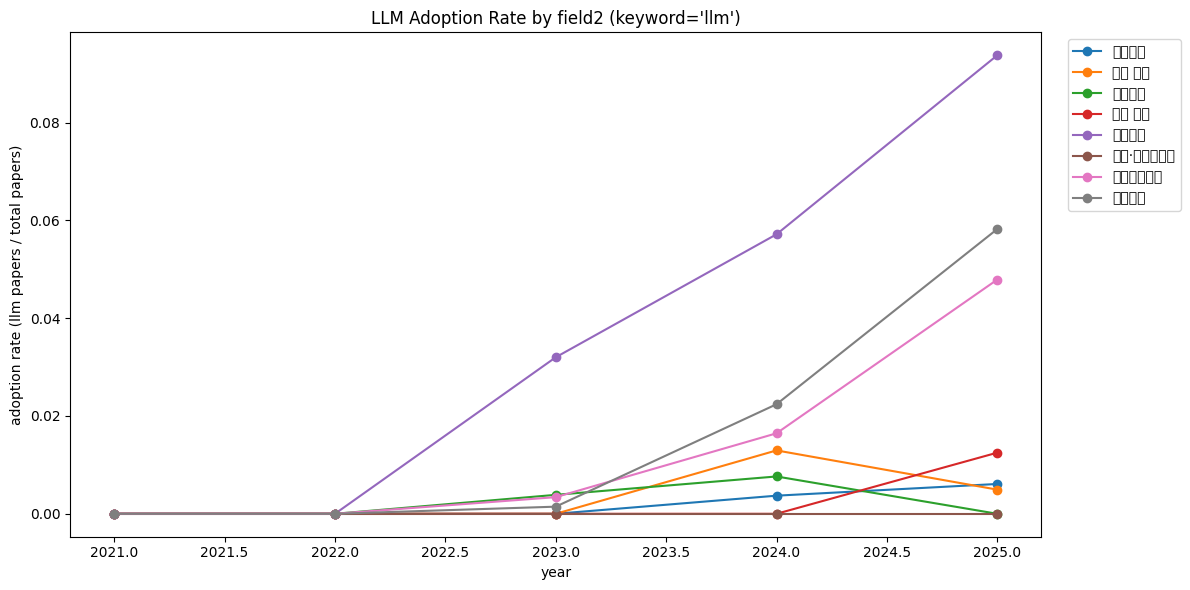

field2,건축공학,공학 일반,기계공학,기타 공학,산업공학,재료·에너지공학,전기전자공학,컴퓨터학
year,,,,,,,,
2021,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.000000
2022,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.000000
2023,0.000000,0.000000,0.003876,0.0000,0.032000,0.0,0.003404,0.001458
2024,0.003704,0.012959,0.007634,0.0000,0.057143,0.0,0.016458,0.022398
2025,0.006098,0.004938,0.000000,0.0125,0.093750,0.0,0.047887,0.058219


In [ ]:
# 1) LLM 채택률(Adoption Rate) 분석 설정
# - adoption keyword: "llm"
# - 분모: 해당 연도×field2 전체 논문 수
# - 분자: 해당 연도×field2 중 "llm" 포함 논문 수
adopt_kw = "llm"

df = papers_net2.copy()  # 정규화/희귀제거까지 끝난 데이터 사용
df["field2"] = df["field2"].fillna("미상").astype(str).str.strip()

# 2) 연도×field2 전체 논문 수(분모)
den = (
    df.groupby(["year", "field2"])["NODE_ID"]
    .count()
    .rename("total_papers")
    .reset_index()
)

# 3) 연도×field2 LLM 포함 논문 수(분자)
num = (
    df[df["kw_list_f"].apply(lambda ks: adopt_kw in ks)]
    .groupby(["year", "field2"])["NODE_ID"]
    .count()
    .rename("llm_papers")
    .reset_index()
)

# 4) 합치고 채택률 계산
rate = den.merge(num, on=["year", "field2"], how="left")
rate["llm_papers"] = rate["llm_papers"].fillna(0).astype(int)
rate["adoption_rate"] = rate["llm_papers"] / rate["total_papers"]

# 5) 시각화 대상 field2 선정
# - 전체 기간(2021~2025) LLM 논문 수가 많은 field2 상위 N개만
top_n = 8
top_fields = (
    rate.groupby("field2")["llm_papers"]
    .sum()
    .sort_values(ascending=False)
    .head(top_n)
    .index
)

plot_df = rate[rate["field2"].isin(top_fields)].copy()
pivot = plot_df.pivot_table(index="year", columns="field2", values="adoption_rate", fill_value=0)

# 6) 라인 차트 출력
ax = pivot.plot(figsize=(12, 6), marker="o")
ax.set_title(f"LLM Adoption Rate by field2 (keyword='{adopt_kw}')")
ax.set_xlabel("year")
ax.set_ylabel("adoption rate (llm papers / total papers)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 7) 표로도 확인(상위 field2의 연도별 채택률)
display(pivot)

In [ ]:
# 1) 설정: 채택 키워드(LLM)
adopt_kw = "llm"

df = papers_net2.copy()
df["field2"] = df["field2"].fillna("미상").astype(str).str.strip()

# 2) 분모: 연도×field2 전체 논문 수
den = (
    df.groupby(["year", "field2"])["NODE_ID"]
    .count()
    .rename("total_papers")
    .reset_index()
)

# 3) 분자: 연도×field2 중 LLM 포함 논문 수
num = (
    df[df["kw_list_f"].apply(lambda ks: adopt_kw in ks)]
    .groupby(["year", "field2"])["NODE_ID"]
    .count()
    .rename("llm_papers")
    .reset_index()
)

# 4) 합치고 채택률 계산
rate_tbl = den.merge(num, on=["year", "field2"], how="left")
rate_tbl["llm_papers"] = rate_tbl["llm_papers"].fillna(0).astype(int)
rate_tbl["adoption_rate"] = rate_tbl["llm_papers"] / rate_tbl["total_papers"]

# 5) 전체 표 확인(필요하면 여기서 필터/정렬해서 사용)
rate_tbl = rate_tbl.sort_values(["year", "adoption_rate"], ascending=[True, False])
print("rate_tbl shape:", rate_tbl.shape)
display(rate_tbl.head(20))

# 6) 2025년 기준 랭킹(분모/분자 같이 제시해서 '분모가 작아서 튄다' 반박 대비)
tbl_2025 = rate_tbl[rate_tbl["year"] == 2025].copy()

print("\n[2025] Adoption rate TOP 10 (rate, llm_papers, total_papers)")
display(tbl_2025.sort_values("adoption_rate", ascending=False).head(10))

print("\n[2025] LLM papers TOP 10 (llm_papers, rate, total_papers)")
display(tbl_2025.sort_values("llm_papers", ascending=False).head(10))

print("\n[2025] Total papers TOP 10 (total_papers, llm_papers, rate)")
display(tbl_2025.sort_values("total_papers", ascending=False).head(10))

rate_tbl shape: (50, 5)


,year,field2,total_papers,llm_papers,adoption_rate
0,2021,건축공학,559,0,0.0
1,2021,공학 일반,428,0,0.0
2,2021,기계공학,240,0,0.0
3,2021,기타 공학,92,0,0.0
4,2021,산업공학,92,0,0.0
5,2021,재료·에너지공학,44,0,0.0
6,2021,전기전자공학,1155,0,0.0
7,2021,조선해양공학,6,0,0.0
8,2021,컴퓨터학,598,0,0.0
9,2021,화학공학,34,0,0.0



[2025] Adoption rate TOP 10 (rate, llm_papers, total_papers)


,year,field2,total_papers,llm_papers,adoption_rate
44,2025,산업공학,96,9,0.093750
48,2025,컴퓨터학,584,34,0.058219
46,2025,전기전자공학,1065,51,0.047887
43,2025,기타 공학,80,1,0.012500
40,2025,건축공학,492,3,0.006098
41,2025,공학 일반,405,2,0.004938
42,2025,기계공학,198,0,0.000000
45,2025,재료·에너지공학,34,0,0.000000
47,2025,조선해양공학,8,0,0.000000
49,2025,화학공학,23,0,0.000000



[2025] LLM papers TOP 10 (llm_papers, rate, total_papers)


,year,field2,total_papers,llm_papers,adoption_rate
46,2025,전기전자공학,1065,51,0.047887
48,2025,컴퓨터학,584,34,0.058219
44,2025,산업공학,96,9,0.093750
40,2025,건축공학,492,3,0.006098
41,2025,공학 일반,405,2,0.004938
43,2025,기타 공학,80,1,0.012500
42,2025,기계공학,198,0,0.000000
45,2025,재료·에너지공학,34,0,0.000000
47,2025,조선해양공학,8,0,0.000000
49,2025,화학공학,23,0,0.000000



[2025] Total papers TOP 10 (total_papers, llm_papers, rate)


,year,field2,total_papers,llm_papers,adoption_rate
46,2025,전기전자공학,1065,51,0.047887
48,2025,컴퓨터학,584,34,0.058219
40,2025,건축공학,492,3,0.006098
41,2025,공학 일반,405,2,0.004938
42,2025,기계공학,198,0,0.000000
44,2025,산업공학,96,9,0.093750
43,2025,기타 공학,80,1,0.012500
45,2025,재료·에너지공학,34,0,0.000000
49,2025,화학공학,23,0,0.000000
47,2025,조선해양공학,8,0,0.000000


In [ ]:
# 1) 분석 설정
target_field2 = "산업공학"
anchor_kw = "llm"

df = papers_net2.copy()
df["field2"] = df["field2"].fillna("미상").astype(str).str.strip()

# 2) 산업공학 + LLM 포함 논문 필터링
sub = df[(df["field2"] == target_field2) & (df["kw_list_f"].apply(lambda ks: anchor_kw in ks))].copy()

print("filtered papers:", sub.shape[0])
print("year range:", sub["year"].min(), "~", sub["year"].max())

# 3) 전체 기간(필터된 논문 집합)에서 LLM과 같이 등장한 키워드 Top 30
all_kws = []
for ks in sub["kw_list_f"]:
    for k in ks:
        if k != anchor_kw:
            all_kws.append(k)

top30 = Counter(all_kws).most_common(30)
top30_df = pd.DataFrame(top30, columns=["keyword", "count"])

print("\nTop 30 co-occurring keywords with LLM (Industrial Engineering, all years):")
display(top30_df)

# 4) 연도별 Top 15 (LLM과 같이 등장한 키워드가 어떻게 바뀌는지)
years = sorted(sub["year"].unique())
for y in years:
    sub_y = sub[sub["year"] == y]
    kws_y = []
    for ks in sub_y["kw_list_f"]:
        kws_y.extend([k for k in ks if k != anchor_kw])

    top15_y = Counter(kws_y).most_common(15)
    print(f"\n[{y}] Top 15 co-occurring keywords with LLM in {target_field2} (n={len(sub_y)} papers)")
    display(pd.DataFrame(top15_y, columns=["keyword", "count"]))

filtered papers: 19
year range: 2023 ~ 2025

Top 30 co-occurring keywords with LLM (Industrial Engineering, all years):


,keyword,count
0,대규모 언어 모델,5
1,검색 증강 생성,4
2,거대언어모델,3
3,generative ai,3
4,information retrieval,2
5,프롬프트 엔지니어링,2
6,prompt engineering,2
7,rag,2
8,text mining,2
9,chatbot,1



[2023] Top 15 co-occurring keywords with LLM in 산업공학 (n=4 papers)


,keyword,count
0,거대언어모델,3
1,generative ai,2
2,생성형 ai,1
3,검색 증강 생성,1
4,rag,1
5,프롬프트 엔지니어링,1
6,chatgpt,1
7,prompt engineering,1
8,gpt,1



[2024] Top 15 co-occurring keywords with LLM in 산업공학 (n=6 papers)


,keyword,count
0,검색 증강 생성,3
1,대규모 언어 모델,2
2,데이터 증강,1
3,언어 모델,1
4,data augmentation,1
5,language model,1
6,classification model,1
7,대형 언어 모델,1
8,rag,1
9,텍스트 마이닝,1



[2025] Top 15 co-occurring keywords with LLM in 산업공학 (n=9 papers)


,keyword,count
0,대규모 언어 모델,3
1,information retrieval,2
2,chatbot,1
3,recommendation,1
4,retrieval-augmented generation,1
5,생성형 인공지능,1
6,generative ai,1
7,프롬프트 엔지니어링,1
8,prompt engineering,1
9,fine-tuning,1


In [ ]:
# 1) 대상: 산업공학 + llm 포함 논문만 (앞에서 만든 sub가 있으면 그걸 그대로 써도 됨)
target_field2 = "산업공학"
anchor_kw = "llm"

df = papers_net2.copy()
df["field2"] = df["field2"].fillna("미상").astype(str).str.strip()

sub = df[(df["field2"] == target_field2) & (df["kw_list_f"].apply(lambda ks: anchor_kw in ks))].copy()

print("filtered papers:", sub.shape[0])
print("year range:", sub["year"].min(), "~", sub["year"].max())

# 2) 표준화 규칙(동의어 병합)
# - 필요한 규칙은 나중에 계속 추가/수정 가능
CANON = {
    # LLM 관련(한글/영문 변형들)
    "대규모 언어 모델": "llm",
    "대형 언어 모델": "llm",
    "거대 언어 모델": "llm",
    "거대언어모델": "llm",
    "대형언어모델": "llm",
    "대규모언어모델": "llm",
    "언어 모델": "language model",
    "language model": "language model",

    # RAG 관련
    "검색 증강 생성": "rag",
    "검색증강생성": "rag",
    "rag": "rag",
    "retrieval-augmented generation": "rag",

    # 프롬프트 엔지니어링
    "프롬프트 엔지니어링": "prompt engineering",
    "prompt engineering": "prompt engineering",

    # 텍스트 마이닝
    "텍스트 마이닝": "text mining",
    "text mining": "text mining",

    # 생성형 AI
    "생성형 인공지능": "generative ai",
    "생성형 ai": "generative ai",
    "generative ai": "generative ai",

    # 지식 그래프
    "지식 그래프": "knowledge graph",
    "knowledge graph": "knowledge graph",
}

def normalize_kw(k: str) -> str:
    """
    키워드 표준화:
    - 소문자화, 공백 정리
    - CANON 사전에 있는 표현은 대표 표현으로 병합
    """
    if not isinstance(k, str):
        return ""
    k = k.strip().lower()
    k = re.sub(r"\s+", " ", k)

    # 원문이 한글이면 lower() 영향이 없고, 영문은 소문자화됨
    # CANON 키도 소문자 기준으로 맞추기 위해 매칭도 소문자 기준
    return CANON.get(k, k)

# 3) 표준화된 키워드 리스트 생성(각 논문마다)
sub["kw_list_norm"] = sub["kw_list_f"].apply(lambda ks: sorted({normalize_kw(k) for k in ks if normalize_kw(k)}))

# 4) 전체 기간: LLM과 같이 등장한 키워드 Top 30 (표준화 버전)
all_norm = []
for ks in sub["kw_list_norm"]:
    for k in ks:
        if k != anchor_kw:
            all_norm.append(k)

top30_norm = Counter(all_norm).most_common(30)
top30_norm_df = pd.DataFrame(top30_norm, columns=["keyword_norm", "count"])

print("\nTop 30 co-occurring keywords with LLM (Industrial Engineering, normalized):")
display(top30_norm_df)

# 5) 연도별 Top 15 (표준화 버전)
years = sorted(sub["year"].unique())
for y in years:
    sub_y = sub[sub["year"] == y]
    kws_y = []
    for ks in sub_y["kw_list_norm"]:
        kws_y.extend([k for k in ks if k != anchor_kw])

    top15_y = Counter(kws_y).most_common(15)
    print(f"\n[{y}] Top 15 co-occurring keywords with LLM in {target_field2} (normalized) (n={len(sub_y)} papers)")
    display(pd.DataFrame(top15_y, columns=["keyword_norm", "count"]))

# 6) 참고: 표준화 전/후 unique 키워드 수 비교(얼마나 정리됐는지)
orig_unique = len(set([k for ks in sub["kw_list_f"] for k in ks]))
norm_unique = len(set([k for ks in sub["kw_list_norm"] for k in ks]))
print("\nunique keywords (orig -> norm):", orig_unique, "->", norm_unique)

filtered papers: 19
year range: 2023 ~ 2025

Top 30 co-occurring keywords with LLM (Industrial Engineering, normalized):


,keyword_norm,count
0,rag,6
1,generative ai,3
2,information retrieval,2
3,prompt engineering,2
4,text mining,2
5,chatbot,1
6,recommendation,1
7,fine-tuning,1
8,classification model,1
9,data augmentation,1



[2023] Top 15 co-occurring keywords with LLM in 산업공학 (normalized) (n=4 papers)


,keyword_norm,count
0,generative ai,2
1,rag,1
2,chatgpt,1
3,gpt,1
4,prompt engineering,1



[2024] Top 15 co-occurring keywords with LLM in 산업공학 (normalized) (n=6 papers)


,keyword_norm,count
0,rag,4
1,classification model,1
2,data augmentation,1
3,language model,1
4,데이터 증강,1
5,text mining,1
6,kobert,1
7,knowledge graph,1



[2025] Top 15 co-occurring keywords with LLM in 산업공학 (normalized) (n=9 papers)


,keyword_norm,count
0,information retrieval,2
1,chatbot,1
2,rag,1
3,recommendation,1
4,generative ai,1
5,fine-tuning,1
6,prompt engineering,1
7,automation,1
8,text mining,1
9,time series forecasting,1



unique keywords (orig -> norm): 35 -> 23
